In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [2]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, LongType, Row
from pyspark.sql.functions import split, explode, col, countDistinct, count, udf, regexp_extract, to_date, from_unixtime
from pyspark.sql.functions import mean as _mean
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20,8)
#plt.figure(figsize=(20,15))

In [3]:
MOVIES_CSV_FILE = "ml-20m/movies.csv"

In [14]:
movies_df = spark.read.load(MOVIES_CSV_FILE, format="csv", sep=",", mode="FAILFAST", inferSchema="true", header="true")

In [15]:
movies_df

DataFrame[movieId: int, title: string, genres: string]

In [16]:
movies_df.count()

27278

In [17]:
movies_df.take(10)

[Row(movieId=1, title='Toy Story (1995)', genres='Adventure|Animation|Children|Comedy|Fantasy'),
 Row(movieId=2, title='Jumanji (1995)', genres='Adventure|Children|Fantasy'),
 Row(movieId=3, title='Grumpier Old Men (1995)', genres='Comedy|Romance'),
 Row(movieId=4, title='Waiting to Exhale (1995)', genres='Comedy|Drama|Romance'),
 Row(movieId=5, title='Father of the Bride Part II (1995)', genres='Comedy'),
 Row(movieId=6, title='Heat (1995)', genres='Action|Crime|Thriller'),
 Row(movieId=7, title='Sabrina (1995)', genres='Comedy|Romance'),
 Row(movieId=8, title='Tom and Huck (1995)', genres='Adventure|Children'),
 Row(movieId=9, title='Sudden Death (1995)', genres='Action'),
 Row(movieId=10, title='GoldenEye (1995)', genres='Action|Adventure|Thriller')]

In [18]:
movies_df.show()

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

In [19]:
movies_df.first()

Row(movieId=1, title='Toy Story (1995)', genres='Adventure|Animation|Children|Comedy|Fantasy')

In [20]:
movies_df.sample(withReplacement=False,fraction=0.001,seed=0xcafebabe).collect()

[Row(movieId=88, title='Black Sheep (1996)', genres='Comedy'),
 Row(movieId=100, title='City Hall (1996)', genres='Drama|Thriller'),
 Row(movieId=420, title='Beverly Hills Cop III (1994)', genres='Action|Comedy|Crime|Thriller'),
 Row(movieId=2394, title='Prince of Egypt, The (1998)', genres='Animation|Musical'),
 Row(movieId=3278, title='Gendernauts (1999)', genres='Documentary'),
 Row(movieId=4548, title='Sunset (1988)', genres='Action|Comedy|Thriller|Western'),
 Row(movieId=4952, title='Morons From Outer Space (1985)', genres='Comedy|Sci-Fi'),
 Row(movieId=5898, title='Sword and the Sorcerer, The (1982)', genres='Action|Adventure|Fantasy'),
 Row(movieId=7183, title="There's a Girl in My Soup (1970)", genres='Comedy'),
 Row(movieId=7725, title='On Deadly Ground (1994)', genres='Action|Adventure|Thriller'),
 Row(movieId=31330, title='Strawberries in the Supermarket (Jagoda u supermarketu) (2003) ', genres='Action|Adventure|Comedy'),
 Row(movieId=31894, title='ChubbChubbs!, The (2002)',

In [21]:
movies_genres_df = movies_df.select(col("movieId"), explode(split(col('genres'),'\|')).alias("genre"))

In [22]:
movies_genres_df.show()

+-------+---------+
|movieId|    genre|
+-------+---------+
|      1|Adventure|
|      1|Animation|
|      1| Children|
|      1|   Comedy|
|      1|  Fantasy|
|      2|Adventure|
|      2| Children|
|      2|  Fantasy|
|      3|   Comedy|
|      3|  Romance|
|      4|   Comedy|
|      4|    Drama|
|      4|  Romance|
|      5|   Comedy|
|      6|   Action|
|      6|    Crime|
|      6| Thriller|
|      7|   Comedy|
|      7|  Romance|
|      8|Adventure|
+-------+---------+
only showing top 20 rows



In [23]:
movies_genres_df.groupBy("genre").agg(count("genre").alias('number')).where("genre != '(no genres listed)'").show()

+-----------+------+
|      genre|number|
+-----------+------+
|      Crime|  2939|
|    Romance|  4127|
|   Thriller|  4178|
|  Adventure|  2329|
|      Drama| 13344|
|        War|  1194|
|Documentary|  2471|
|    Fantasy|  1412|
|    Mystery|  1514|
|    Musical|  1036|
|  Animation|  1027|
|  Film-Noir|   330|
|       IMAX|   196|
|     Horror|  2611|
|    Western|   676|
|     Comedy|  8374|
|   Children|  1139|
|     Action|  3520|
|     Sci-Fi|  1743|
+-----------+------+



In [26]:
def extract_year(x):
    if x[-5:-1].isdigit():
        return int(x[-5:-1])
    else:
        return None


udf_extract_year = udf(extract_year, IntegerType())

In [27]:
%time movies_df.withColumn("year",udf_extract_year(col('title'))).show()

+-------+--------------------+--------------------+----+
|movieId|               title|              genres|year|
+-------+--------------------+--------------------+----+
|      1|    Toy Story (1995)|Adventure|Animati...|1995|
|      2|      Jumanji (1995)|Adventure|Childre...|1995|
|      3|Grumpier Old Men ...|      Comedy|Romance|1995|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|1995|
|      5|Father of the Bri...|              Comedy|1995|
|      6|         Heat (1995)|Action|Crime|Thri...|1995|
|      7|      Sabrina (1995)|      Comedy|Romance|1995|
|      8| Tom and Huck (1995)|  Adventure|Children|1995|
|      9| Sudden Death (1995)|              Action|1995|
|     10|    GoldenEye (1995)|Action|Adventure|...|1995|
|     11|American Presiden...|Comedy|Drama|Romance|1995|
|     12|Dracula: Dead and...|       Comedy|Horror|1995|
|     13|        Balto (1995)|Adventure|Animati...|1995|
|     14|        Nixon (1995)|               Drama|1995|
|     15|Cutthroat Island ...|A

In [28]:
_ = movies_df.withColumn("year",regexp_extract(col('title'), '\((\d{4})\)',1)).filter("year != ''").groupby('year').count().sort(col("year").asc()).toPandas()

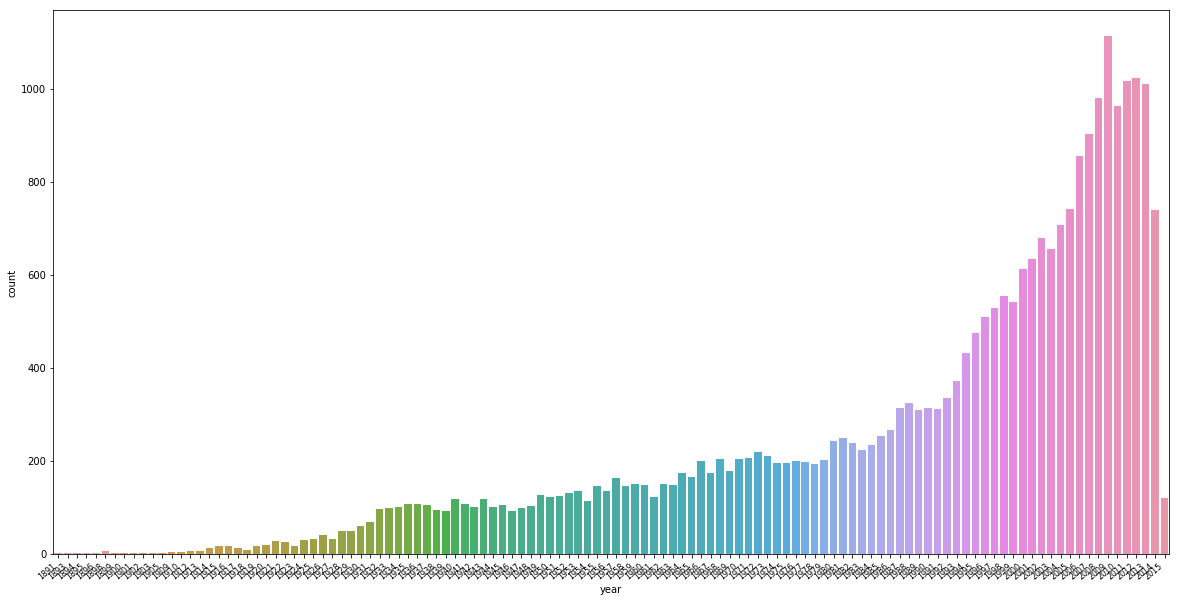

In [29]:
plt.figure(figsize=(20,10))
ax = sns.barplot(x="year", y="count", data=_)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=8)
plt.show()

In [31]:
RATINGS_CSV_FILE = "ml-20m/ratings.csv"

In [32]:
ratings_schema = StructType([
    StructField("userId", IntegerType()),
    StructField("movieId", IntegerType()),
    StructField("rating", FloatType()),
    StructField("timestamp", LongType())    
])

In [33]:
ratings_df = spark.read.csv(RATINGS_CSV_FILE, header=True, mode="FAILFAST", schema=ratings_schema)

In [34]:
ratings_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: float (nullable = true)
 |-- timestamp: long (nullable = true)



In [35]:
ratings_df.show()

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|      2|   3.5|1112486027|
|     1|     29|   3.5|1112484676|
|     1|     32|   3.5|1112484819|
|     1|     47|   3.5|1112484727|
|     1|     50|   3.5|1112484580|
|     1|    112|   3.5|1094785740|
|     1|    151|   4.0|1094785734|
|     1|    223|   4.0|1112485573|
|     1|    253|   4.0|1112484940|
|     1|    260|   4.0|1112484826|
|     1|    293|   4.0|1112484703|
|     1|    296|   4.0|1112484767|
|     1|    318|   4.0|1112484798|
|     1|    337|   3.5|1094785709|
|     1|    367|   3.5|1112485980|
|     1|    541|   4.0|1112484603|
|     1|    589|   3.5|1112485557|
|     1|    593|   3.5|1112484661|
|     1|    653|   3.0|1094785691|
|     1|    919|   3.5|1094785621|
+------+-------+------+----------+
only showing top 20 rows



In [36]:
ratings_df = ratings_df.withColumn("time", to_date(from_unixtime(col("timestamp")))).drop(col('timestamp'))

In [37]:
ratings_df.first()

Row(userId=1, movieId=2, rating=3.5, time=datetime.date(2005, 4, 3))

In [38]:
ratings_df.select(
    _mean(col('rating')).alias('mean_rating'),
).collect()

[Row(mean_rating=3.5255285642993797)]

## Group

In [39]:
%time ratings_df.groupBy('movieId').agg(_mean('rating')).show()

+-------+------------------+
|movieId|       avg(rating)|
+-------+------------------+
|   3997|2.0703468490473864|
|   1580|  3.55831928049466|
|   3918| 2.918940609951846|
|   2366|3.5492681454655197|
|   3175| 3.600717102904267|
|   4519|3.2463842975206614|
|   1591|2.6201712654614653|
|    471|3.6641817536386228|
|  36525| 3.482891360136869|
|  44022| 3.334077079107505|
|   2866| 3.605188343994314|
|   1645|3.4787484726828417|
|   5803| 2.772944550669216|
|  54190|3.6701244813278007|
|   1088| 3.209207300463089|
|    833| 2.725998598458304|
|   8638|3.9375181211945494|
|    463|               2.8|
|   1959| 3.628987240829346|
|   2659|3.2326923076923078|
+-------+------------------+
only showing top 20 rows

CPU times: user 4 ms, sys: 531 µs, total: 4.53 ms
Wall time: 6.36 s


## Best 20 movies

In [40]:
%time ratings_df.groupby('movieId')\
          .agg(count("rating").alias('count_rating'),_mean("rating").alias('avg_rating'))\
          .join(movies_df,"movieId",'inner')\
          .filter(col('count_rating') > 50)\
          .sort(col('avg_rating').desc()).show(20)

+-------+------------+------------------+--------------------+--------------------+
|movieId|count_rating|        avg_rating|               title|              genres|
+-------+------------+------------------+--------------------+--------------------+
|    318|       63366| 4.446990499637029|Shawshank Redempt...|         Crime|Drama|
|    858|       41355| 4.364732196832306|Godfather, The (1...|         Crime|Drama|
|     50|       47006| 4.334372207803259|Usual Suspects, T...|Crime|Mystery|Thr...|
|    527|       50054| 4.310175010988133|Schindler's List ...|           Drama|War|
|   1221|       27398| 4.275640557704942|Godfather: Part I...|         Crime|Drama|
|   2019|       11611|   4.2741796572216|Seven Samurai (Sh...|Action|Adventure|...|
|    904|       17449| 4.271333600779414|  Rear Window (1954)|    Mystery|Thriller|
|   7502|        4305| 4.263182346109176|Band of Brothers ...|    Action|Drama|War|
|    912|       24349| 4.258326830670664|   Casablanca (1942)|       Drama|R

In [41]:
ratings_df.groupby('movieId')\
          .agg(count("rating").alias('count_rating'),_mean("rating").alias('avg_rating'))\
          .join(movies_df,"movieId",'inner')\
          .filter(col('count_rating') > 50)\
          .sort(col('avg_rating').desc()).explain()

== Physical Plan ==
*(4) Sort [avg_rating#315 DESC NULLS LAST], true, 0
+- Exchange rangepartitioning(avg_rating#315 DESC NULLS LAST, 200)
   +- *(3) Project [movieId#196, count_rating#313L, avg_rating#315, title#89, genres#90]
      +- *(3) BroadcastHashJoin [movieId#196], [movieId#88], Inner, BuildRight
         :- *(3) Filter (count_rating#313L > 50)
         :  +- *(3) HashAggregate(keys=[movieId#196], functions=[count(rating#197), avg(cast(rating#197 as double))])
         :     +- Exchange hashpartitioning(movieId#196, 200)
         :        +- *(1) HashAggregate(keys=[movieId#196], functions=[partial_count(rating#197), partial_avg(cast(rating#197 as double))])
         :           +- *(1) Project [movieId#196, rating#197]
         :              +- *(1) Filter isnotnull(movieId#196)
         :                 +- *(1) FileScan csv [movieId#196,rating#197] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/home/cindy/Documents/Scolaire/DAD/spark/ml-20m/ratings.csv], Pa